In [ ]:
import sys
!{sys.executable} -m ensurepip --upgrade
!{sys.executable} -m pip install pyarrow  # Or fastparquet

/usr/bin/python3: No module named ensurepip


In [ ]:
import sys
!{sys.executable} -m pip install nltk

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Make sure to download these before running if you haven't already
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import pandas as pd
df = pd.read_parquet('/content/acl-publication-info.74k.v2.parquet')
df.head(1)

,acl_id,abstract,full_text,corpus_paper_id,pdf_hash,numcitedby,url,publisher,address,year,...,doi,number,volume,journal,editor,isbn,ENTRYTYPE,ID,language,note
0,O02-2002,There is a need to measure word similarity whe...,There is a need to measure word similarity whe...,18022704,0b09178ac8d17a92f16140365363d8df88c757d0,14,https://aclanthology.org/O02-2002,None,None,2002,...,None,None,None,None,None,None,inproceedings,chen-you-2002-study,None,None


In [ ]:
df['numcitedby']

0         14
1         93
2         10
3         15
4         12
        ... 
73280     11
73281     12
73282     14
73283     92
73284    330
Name: numcitedby, Length: 73285, dtype: int64

In [ ]:
# Step 1: Filter relevant data
# We are assuming ChatGPT may not have been directly referenced in earlier papers and are using broader terms.
relevant_terms = ['ChatGPT', 'GPT', 'OpenAI', 'transformer', 'language model']
chatgpt_research = df[df['abstract'].str.contains('|'.join(relevant_terms), case=False, na=False) |
                      df['full_text'].str.contains('|'.join(relevant_terms), case=False, na=False)]

# Step 2: Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if text is None:
        return ''
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords and lemmatize the words
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(text)

# Apply text preprocessing to the abstracts
chatgpt_research.loc[:, 'processed_abstract'] = chatgpt_research['abstract'].apply(preprocess_text)

<ipython-input-7-47af7eb71f6c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chatgpt_research.loc[:, 'processed_abstract'] = chatgpt_research['abstract'].apply(preprocess_text)


In [ ]:
chatgpt_research.loc[:, 'processed_abstract'] = chatgpt_research['abstract'].apply(preprocess_text)

<ipython-input-8-011b0fe95995>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chatgpt_research.loc[:, 'processed_abstract'] = chatgpt_research['abstract'].apply(preprocess_text)


In [ ]:
chatgpt_research.loc[:, 'processed_abstract']

9        statistical machine translation system use com...
11       improve upon previous line work parsing web da...
12       eleven group participated event paper describe...
15       work discus translation result four euparl dat...
16       rule based machine translation method require ...
                               ...                        
73269    describe nrccnrc system submitted americasnlp ...
73272    internet facilitated userbase platform communi...
73274    internet advancement made huge impact communic...
73275    paper describes system constraint challenge ac...
73280    paper describes recent progress author perspec...
Name: processed_abstract, Length: 23053, dtype: object

In [ ]:
chatgpt_research

,acl_id,abstract,full_text,corpus_paper_id,pdf_hash,numcitedby,url,publisher,address,year,...,number,volume,journal,editor,isbn,ENTRYTYPE,ID,language,note,processed_abstract
9,W05-0821,Statistical machine translation systems use a ...,Statistical machine translation systems use a ...,1966857,2a05c9c5373a3e1e01b8161e6687b960ab3d2ff5,55,https://aclanthology.org/W05-0821,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,None,None,inproceedings,kirchhoff-yang-2005-improved,None,None,statistical machine translation system use com...
11,R13-1046,We improve upon a previous line of work for pa...,We improve upon a previous line of work for pa...,7403488,778382f4099a5d478c1f68e1bb46fc7c26013a5c,11,https://aclanthology.org/R13-1046,"INCOMA Ltd. Shoumen, BULGARIA","Hissar, Bulgaria",2013,...,None,None,None,None,None,inproceedings,khan-etal-2013-towards,None,None,improve upon previous line work parsing web da...
12,W05-0820,Eleven groups participated in the event. This ...,Eleven groups participated in the event. This ...,9271055,5025a4b2b724867f7b6b24f3e9253a61b76a3406,83,https://aclanthology.org/W05-0820,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,None,None,inproceedings,koehn-monz-2005-shared,None,None,eleven group participated event paper describe...
15,W05-0823,This work discusses translation results for th...,This work discusses translation results for th...,8303276,bd500b912faec09be996f76ab49e33eb5a8b5f8f,22,https://aclanthology.org/W05-0823,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,None,None,inproceedings,banchs-etal-2005-statistical,None,None,work discus translation result four euparl dat...
16,2009.mtsummit-posters.23,Rule based machine translation methods require...,Rule based machine translation methods require...,34218208,2e4ffd53b290960a18679c8d6f3db4e03bbacdc8,3,https://aclanthology.org/2009.mtsummit-posters.23,None,"Ottawa, Canada",2009,...,None,None,None,None,None,inproceedings,varga-yokoyama-2009-transfer,None,None,rule based machine translation method require ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73269,2021.americasnlp-1.25,We describe the NRC-CNRC systems submitted to ...,We describe the NRC-CNRC systems submitted to ...,235097526,2179c387d5cfef7388770acb83ca2a625d0ce7c0,2,https://aclanthology.org/2021.americasnlp-1.25,Association for Computational Linguistics,Online,2021,...,None,None,None,None,None,inproceedings,knowles-etal-2021-nrc,None,None,describe nrccnrc system submitted americasnlp ...
73272,2021.dravidianlangtech-1.16,The internet has facilitated its user-base wit...,The internet has facilitated its user-base wit...,233365114,59f378d05209dfa77d9c15cc210f8b63f64c5b3b,45,https://aclanthology.org/2021.dravidianlangtec...,Association for Computational Linguistics,Kyiv,2021,...,None,None,None,None,None,inproceedings,suryawanshi-chakravarthi-2021-findings,None,None,internet facilitated userbase platform communi...
73274,2021.dravidianlangtech-1.53,Internet advancements have made a huge impact ...,Internet advancements have made a huge impact ...,233365324,13c3f469bc074a0b1be27ad0305bfe55ad0c96a8,3,https://aclanthology.org/2021.dravidianlangtec...,Association for Computational Linguistics,Kyiv,2021,...,None,None,None,None,None,inproceedings,rajalakshmi-etal-2021-dlrg,None,None,internet advancement made huge impact communic...
73275,2022.constraint-1.4,This paper describes our system for the Constr...,This paper describes our system for the Constr...,248780297,6d2b1be319c4e740460e2e8b7835b97b71d0336d,1,https://aclanthology.org/2022.constraint-1.4,Association for Computational Linguistics,"Dublin, Ireland",2022,...,None,None,None,None,None,inproceedings,kun-etal-2022-logically,None,None,paper describes system constraint challenge ac...


In [ ]:
# Step 3: Keyword Extraction
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(chatgpt_research['processed_abstract'])

lda = LatentDirichletAllocation(n_components=10, random_state=0)
# Step 4: Topic Modeling
lda.fit(data_cv)

# Retrieve the words that have the highest probability for each topic
feature_names = cv.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))

Topic #0:
error language text paper chinese corpus arabic correction method word
Topic #1:
model question text task knowledge dataset information event answer human
Topic #2:
le la et argument en nous pour une dans sur
Topic #3:
word model language embeddings representation context information method using approach
Topic #4:
translation machine model language data statistical mt sentence bleu paper
Topic #5:
language corpus evaluation text metric english data human domain automatic
Topic #6:
task model language paper shared feature result classification data approach
Topic #7:
model task data method language training performance learning propose pretrained
Topic #8:
model approach structure tree method information result paper graph parsing
Topic #9:
speech dialogue user response recognition language model utterance conversation dialog


In [ ]:
# Step 5: Trend Analysis

trend_analysis = chatgpt_research.groupby('year')['acl_id'].count()

# Trend analysis results
print(trend_analysis)

year
1967       1
1969       1
1973       2
1976       2
1977       1
1978       1
1980       2
1981       3
1982       2
1983       1
1986       4
1987       5
1988       8
1989      41
1990      32
1991      46
1992      71
1993      52
1994      77
1995      34
1996      49
1997      83
1998     114
1999      62
2000      82
2001      91
2002      96
2003     197
2004     210
2005     282
2006     353
2007     379
2008     405
2009     507
2010     576
2011     571
2012     656
2013     682
2014     756
2015     726
2016    1012
2017     767
2018    1211
2019    2072
2020    3842
2021    4471
2022    2415
Name: acl_id, dtype: int64


In [ ]:
import sys
!{sys.executable} -m ensurepip --upgrade
!{sys.executable} -m pip install seaborn

/usr/bin/python3: No module named ensurepip


<ipython-input-13-5ce5a517bfed>:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=trend_df, x='year', y='acl_id', palette=palette, marker='o', markersize=8, linewidth=2)


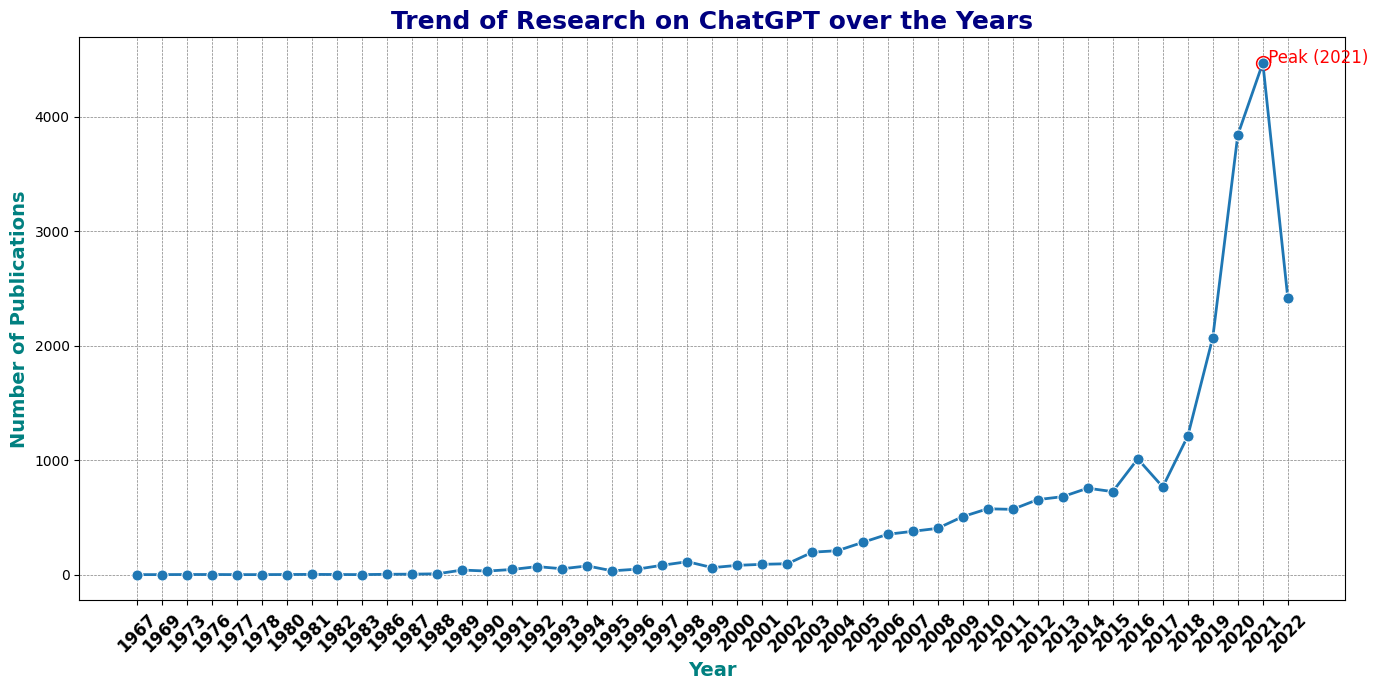

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming trend_analysis is a Series with the index as the year and the values as the counts
# Reset index to convert the Series to DataFrame for plotting
trend_df = trend_analysis.reset_index()

# Enhancing the plot with more creative elements
plt.figure(figsize=(14, 7))

# Using a more sophisticated color palette
palette = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

# Plotting with a lineplot and adding markers
sns.lineplot(data=trend_df, x='year', y='acl_id', palette=palette, marker='o', markersize=8, linewidth=2)

# Adding a title and customizing font properties
plt.title('Trend of Research on ChatGPT over the Years', fontsize=18, fontweight='bold', color='navy')

# Customizing axes labels
plt.xlabel('Year', fontsize=14, fontweight='bold', color='teal')
plt.ylabel('Number of Publications', fontsize=14, fontweight='bold', color='teal')

# Adding a grid for better readability
plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray')

# Customizing the x-ticks for better visibility
plt.xticks(rotation=45, fontsize=12, fontweight='bold')

# Highlighting the maximum point for emphasis
max_year = trend_df['year'][trend_df['acl_id'].idxmax()]
max_count = trend_df['acl_id'].max()
plt.scatter(max_year, max_count, color='red', s=100)  # Mark the point
plt.text(max_year, max_count, f' Peak ({max_year})', color='red', fontsize=12)  # Annotate the point

# Adjusting layout and showing the plot
plt.tight_layout()
plt.show()

In [ ]:
df['country'] = df['address'].apply(lambda x: x.split(',')[-1].strip() if pd.notna(x) else None)

# Aggregate the data by country
publication_counts = df['country'].value_counts()

In [ ]:
import sys
!{sys.executable} -m ensurepip --upgrade
!{sys.executable} -m pip install openpyxl

/usr/bin/python3: No module named ensurepip


In [ ]:
publication_counts.to_excel('publication_counts.xlsx')

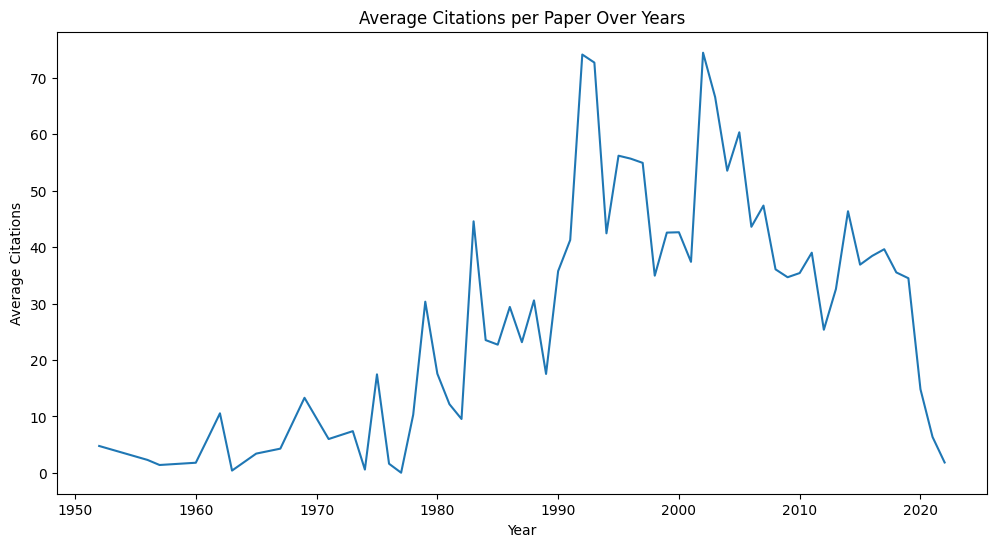

In [ ]:
import seaborn as sns
# Ensure the 'year' and 'numcitedby' columns are in the correct format
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['numcitedby'] = pd.to_numeric(df['numcitedby'], errors='coerce')

# Analysis 1: Overall Citation Trends
citation_trends = df.groupby('year')['numcitedby'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(data=citation_trends)
plt.title('Average Citations per Paper Over Years')
plt.xlabel('Year')
plt.ylabel('Average Citations')
plt.show()

In [ ]:
chatgpt_research.loc[:, 'processed_full_text'] = chatgpt_research['full_text'].apply(preprocess_text)

<ipython-input-13-4b78d119cf8f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chatgpt_research.loc[:, 'processed_full_text'] = chatgpt_research['full_text'].apply(preprocess_text)


In [ ]:
chatgpt_research

,acl_id,abstract,full_text,corpus_paper_id,pdf_hash,numcitedby,url,publisher,address,year,...,volume,journal,editor,isbn,ENTRYTYPE,ID,language,note,processed_abstract,processed_full_text
9,W05-0821,Statistical machine translation systems use a ...,Statistical machine translation systems use a ...,1966857,2a05c9c5373a3e1e01b8161e6687b960ab3d2ff5,55,https://aclanthology.org/W05-0821,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,None,inproceedings,kirchhoff-yang-2005-improved,None,None,statistical machine translation system use com...,statistical machine translation system use com...
11,R13-1046,We improve upon a previous line of work for pa...,We improve upon a previous line of work for pa...,7403488,778382f4099a5d478c1f68e1bb46fc7c26013a5c,11,https://aclanthology.org/R13-1046,"INCOMA Ltd. Shoumen, BULGARIA","Hissar, Bulgaria",2013,...,None,None,None,None,inproceedings,khan-etal-2013-towards,None,None,improve upon previous line work parsing web da...,improve upon previous line work parsing web da...
12,W05-0820,Eleven groups participated in the event. This ...,Eleven groups participated in the event. This ...,9271055,5025a4b2b724867f7b6b24f3e9253a61b76a3406,83,https://aclanthology.org/W05-0820,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,None,inproceedings,koehn-monz-2005-shared,None,None,eleven group participated event paper describe...,eleven group participated event paper describe...
15,W05-0823,This work discusses translation results for th...,This work discusses translation results for th...,8303276,bd500b912faec09be996f76ab49e33eb5a8b5f8f,22,https://aclanthology.org/W05-0823,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,None,inproceedings,banchs-etal-2005-statistical,None,None,work discus translation result four euparl dat...,work discus translation result four euparl dat...
16,2009.mtsummit-posters.23,Rule based machine translation methods require...,Rule based machine translation methods require...,34218208,2e4ffd53b290960a18679c8d6f3db4e03bbacdc8,3,https://aclanthology.org/2009.mtsummit-posters.23,None,"Ottawa, Canada",2009,...,None,None,None,None,inproceedings,varga-yokoyama-2009-transfer,None,None,rule based machine translation method require ...,rule based machine translation method require ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73269,2021.americasnlp-1.25,We describe the NRC-CNRC systems submitted to ...,We describe the NRC-CNRC systems submitted to ...,235097526,2179c387d5cfef7388770acb83ca2a625d0ce7c0,2,https://aclanthology.org/2021.americasnlp-1.25,Association for Computational Linguistics,Online,2021,...,None,None,None,None,inproceedings,knowles-etal-2021-nrc,None,None,describe nrccnrc system submitted americasnlp ...,describe nrccnrc system submitted americasnlp ...
73272,2021.dravidianlangtech-1.16,The internet has facilitated its user-base wit...,The internet has facilitated its user-base wit...,233365114,59f378d05209dfa77d9c15cc210f8b63f64c5b3b,45,https://aclanthology.org/2021.dravidianlangtec...,Association for Computational Linguistics,Kyiv,2021,...,None,None,None,None,inproceedings,suryawanshi-chakravarthi-2021-findings,None,None,internet facilitated userbase platform communi...,internet facilitated userbase platform communi...
73274,2021.dravidianlangtech-1.53,Internet advancements have made a huge impact ...,Internet advancements have made a huge impact ...,233365324,13c3f469bc074a0b1be27ad0305bfe55ad0c96a8,3,https://aclanthology.org/2021.dravidianlangtec...,Association for Computational Linguistics,Kyiv,2021,...,None,None,None,None,inproceedings,rajalakshmi-etal-2021-dlrg,None,None,internet advancement made huge impact communic...,internet advancement made huge impact communic...
73275,2022.constraint-1.4,This paper describes our system for the Constr...,This paper describes our system for the Constr...,248780297,6d2b1be319c4

In [ ]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=75499a72f90fad9802f2b7feffc6d198a67caa4e768fd3d910e069a698acd0db
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
import pandas as pd
from langdetect import detect, LangDetectException, DetectorFactory

In [ ]:
# Ensuring consistent results by initializing the language detector
DetectorFactory.seed = 0

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        # If language detection fails, return None or some default value
        return None

In [ ]:
chatgpt_research['processed_full_text_en']= chatgpt_research['processed_full_text'].apply(lambda text: detect_language(text) if pd.notnull(text) else None)


<ipython-input-18-7379d8c83b5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chatgpt_research['processed_full_text_en']= chatgpt_research['processed_full_text'].apply(lambda text: detect_language(text) if pd.notnull(text) else None)


In [ ]:
unique_languages = chatgpt_research['processed_full_text_en'].unique()

In [ ]:
unique_languages

array(['en', None, 'fr', 'zh-cn', 'vi', 'no', 'ko', 'pt', 'pl', 'nl',
       'hr', 'sq', 'cs', 'ca'], dtype=object)

In [ ]:
value_count_languages = chatgpt_research['processed_full_text_en'].value_counts()

In [ ]:
value_count_languages

en       22688
fr         200
zh-cn       24
ko          12
no          10
vi           5
nl           4
ca           4
sq           3
pt           2
pl           2
hr           1
cs           1
Name: processed_full_text_en, dtype: int64

In [ ]:
chatgpt_research = chatgpt_research[chatgpt_research['processed_full_text_en'] == 'en']

In [ ]:
chatgpt_research

,acl_id,abstract,full_text,corpus_paper_id,pdf_hash,numcitedby,url,publisher,address,year,...,journal,editor,isbn,ENTRYTYPE,ID,language,note,processed_abstract,processed_full_text,processed_full_text_en
9,W05-0821,Statistical machine translation systems use a ...,Statistical machine translation systems use a ...,1966857,2a05c9c5373a3e1e01b8161e6687b960ab3d2ff5,55,https://aclanthology.org/W05-0821,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,inproceedings,kirchhoff-yang-2005-improved,None,None,statistical machine translation system use com...,statistical machine translation system use com...,en
11,R13-1046,We improve upon a previous line of work for pa...,We improve upon a previous line of work for pa...,7403488,778382f4099a5d478c1f68e1bb46fc7c26013a5c,11,https://aclanthology.org/R13-1046,"INCOMA Ltd. Shoumen, BULGARIA","Hissar, Bulgaria",2013,...,None,None,None,inproceedings,khan-etal-2013-towards,None,None,improve upon previous line work parsing web da...,improve upon previous line work parsing web da...,en
12,W05-0820,Eleven groups participated in the event. This ...,Eleven groups participated in the event. This ...,9271055,5025a4b2b724867f7b6b24f3e9253a61b76a3406,83,https://aclanthology.org/W05-0820,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,inproceedings,koehn-monz-2005-shared,None,None,eleven group participated event paper describe...,eleven group participated event paper describe...,en
15,W05-0823,This work discusses translation results for th...,This work discusses translation results for th...,8303276,bd500b912faec09be996f76ab49e33eb5a8b5f8f,22,https://aclanthology.org/W05-0823,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,inproceedings,banchs-etal-2005-statistical,None,None,work discus translation result four euparl dat...,work discus translation result four euparl dat...,en
16,2009.mtsummit-posters.23,Rule based machine translation methods require...,Rule based machine translation methods require...,34218208,2e4ffd53b290960a18679c8d6f3db4e03bbacdc8,3,https://aclanthology.org/2009.mtsummit-posters.23,None,"Ottawa, Canada",2009,...,None,None,None,inproceedings,varga-yokoyama-2009-transfer,None,None,rule based machine translation method require ...,rule based machine translation method require ...,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73269,2021.americasnlp-1.25,We describe the NRC-CNRC systems submitted to ...,We describe the NRC-CNRC systems submitted to ...,235097526,2179c387d5cfef7388770acb83ca2a625d0ce7c0,2,https://aclanthology.org/2021.americasnlp-1.25,Association for Computational Linguistics,Online,2021,...,None,None,None,inproceedings,knowles-etal-2021-nrc,None,None,describe nrccnrc system submitted americasnlp ...,describe nrccnrc system submitted americasnlp ...,en
73272,2021.dravidianlangtech-1.16,The internet has facilitated its user-base wit...,The internet has facilitated its user-base wit...,233365114,59f378d05209dfa77d9c15cc210f8b63f64c5b3b,45,https://aclanthology.org/2021.dravidianlangtec...,Association for Computational Linguistics,Kyiv,2021,...,None,None,None,inproceedings,suryawanshi-chakravarthi-2021-findings,None,None,internet facilitated userbase platform communi...,internet facilitated userbase platform communi...,en
73274,2021.dravidianlangtech-1.53,Internet advancements have made a huge impact ...,Internet advancements have made a huge impact ...,233365324,13c3f469bc074a0b1be27ad0305bfe55ad0c96a8,3,https://aclanthology.org/2021.dravidianlangtec...,Association for Computational Linguistics,Kyiv,2021,...,None,None,None,inproceedings,rajalakshmi-etal-2021-dlrg,None,None,internet advancement made huge impact communic...,internet advancement made huge impact communic...,en
73275,2022.constraint-1.4,This paper describes our system for the Constr...,This paper describes our system for the Constr...,248780297,6d2b1be319c4

In [ ]:
column_data = chatgpt_research[['processed_full_text']]

In [ ]:
column_data.to_excel('processed_full_text.xlsx', index=False)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
value_count_languages.plot(kind='bar')
plt.title('Frequency of Languages in Column')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

In [ ]:
import pandas as pd
from transformers import pipeline

In [ ]:
texts_to_summarize = chatgpt_research['processed_full_text'].tolist()

In [ ]:
summarizer = pipeline("summarization", model="Falconsai/text_summarization")

In [ ]:
def summarize_text(text, max_chunk_length=1024):
    summary_length = min(len(text.split()), max_chunk_length) // 2
    summary = summarizer(text, max_length=summary_length, min_length=5, truncation=True)
    return summary[0]['summary_text']

In [ ]:
chatgpt_research['summary'] = chatgpt_research['processed_full_text'].apply(summarize_text)

# Using Abstract

In [ ]:
pip install langdetect

In [ ]:
import pandas as pd
from langdetect import detect, LangDetectException, DetectorFactory

In [ ]:
# Ensuring consistent results by initializing the language detector
DetectorFactory.seed = 0

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        # If language detection fails, return None or some default value
        return None

In [ ]:
chatgpt_research['processed_abstract_en']= chatgpt_research['processed_abstract'].apply(lambda text: detect_language(text) if pd.notnull(text) else None)

<ipython-input-27-03d4597cb41d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chatgpt_research['processed_abstract_en']= chatgpt_research['processed_abstract'].apply(lambda text: detect_language(text) if pd.notnull(text) else None)


In [ ]:
unique_languages_abstract = chatgpt_research['processed_abstract_en'].unique()

In [ ]:
unique_languages_abstract

array(['en', None, 'fr', 'it', 'sw', 'de', 'nl', 'hu', 'fi', 'da', 'no',
       'pt', 'ca', 'es'], dtype=object)

In [ ]:
count_languages = chatgpt_research['processed_abstract_en'].value_counts()

In [ ]:
count_languages

en    22423
fr       45
de        6
it        4
fi        4
sw        2
pt        2
nl        1
hu        1
da        1
no        1
ca        1
es        1
Name: processed_abstract_en, dtype: int64

In [ ]:
chatgpt_research = chatgpt_research[chatgpt_research['processed_abstract_en'] == 'en']

In [ ]:
chatgpt_research

,acl_id,abstract,full_text,corpus_paper_id,pdf_hash,numcitedby,url,publisher,address,year,...,editor,isbn,ENTRYTYPE,ID,language,note,processed_abstract,processed_full_text,processed_full_text_en,processed_abstract_en
9,W05-0821,Statistical machine translation systems use a ...,Statistical machine translation systems use a ...,1966857,2a05c9c5373a3e1e01b8161e6687b960ab3d2ff5,55,https://aclanthology.org/W05-0821,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,inproceedings,kirchhoff-yang-2005-improved,None,None,statistical machine translation system use com...,statistical machine translation system use com...,en,en
11,R13-1046,We improve upon a previous line of work for pa...,We improve upon a previous line of work for pa...,7403488,778382f4099a5d478c1f68e1bb46fc7c26013a5c,11,https://aclanthology.org/R13-1046,"INCOMA Ltd. Shoumen, BULGARIA","Hissar, Bulgaria",2013,...,None,None,inproceedings,khan-etal-2013-towards,None,None,improve upon previous line work parsing web da...,improve upon previous line work parsing web da...,en,en
12,W05-0820,Eleven groups participated in the event. This ...,Eleven groups participated in the event. This ...,9271055,5025a4b2b724867f7b6b24f3e9253a61b76a3406,83,https://aclanthology.org/W05-0820,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,inproceedings,koehn-monz-2005-shared,None,None,eleven group participated event paper describe...,eleven group participated event paper describe...,en,en
15,W05-0823,This work discusses translation results for th...,This work discusses translation results for th...,8303276,bd500b912faec09be996f76ab49e33eb5a8b5f8f,22,https://aclanthology.org/W05-0823,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,inproceedings,banchs-etal-2005-statistical,None,None,work discus translation result four euparl dat...,work discus translation result four euparl dat...,en,en
16,2009.mtsummit-posters.23,Rule based machine translation methods require...,Rule based machine translation methods require...,34218208,2e4ffd53b290960a18679c8d6f3db4e03bbacdc8,3,https://aclanthology.org/2009.mtsummit-posters.23,None,"Ottawa, Canada",2009,...,None,None,inproceedings,varga-yokoyama-2009-transfer,None,None,rule based machine translation method require ...,rule based machine translation method require ...,en,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73269,2021.americasnlp-1.25,We describe the NRC-CNRC systems submitted to ...,We describe the NRC-CNRC systems submitted to ...,235097526,2179c387d5cfef7388770acb83ca2a625d0ce7c0,2,https://aclanthology.org/2021.americasnlp-1.25,Association for Computational Linguistics,Online,2021,...,None,None,inproceedings,knowles-etal-2021-nrc,None,None,describe nrccnrc system submitted americasnlp ...,describe nrccnrc system submitted americasnlp ...,en,en
73272,2021.dravidianlangtech-1.16,The internet has facilitated its user-base wit...,The internet has facilitated its user-base wit...,233365114,59f378d05209dfa77d9c15cc210f8b63f64c5b3b,45,https://aclanthology.org/2021.dravidianlangtec...,Association for Computational Linguistics,Kyiv,2021,...,None,None,inproceedings,suryawanshi-chakravarthi-2021-findings,None,None,internet facilitated userbase platform communi...,internet facilitated userbase platform communi...,en,en
73274,2021.dravidianlangtech-1.53,Internet advancements have made a huge impact ...,Internet advancements have made a huge impact ...,233365324,13c3f469bc074a0b1be27ad0305bfe55ad0c96a8,3,https://aclanthology.org/2021.dravidianlangtec...,Association for Computational Linguistics,Kyiv,2021,...,None,None,inproceedings,rajalakshmi-etal-2021-dlrg,None,None,internet advancement made huge impact communic...,internet advancement made huge impact communic...,en,en
73275,2022.constraint-1.4,This paper describes our system for the Constr...,This paper describes our system for the Constr...,248780297,6d2b1be319c4e7

In [ ]:
column_data_1 = chatgpt_research[['processed_abstract']]
column_data_1.to_excel('processed_abstract.xlsx', index=False)

In [ ]:
chatgpt_research_first_20 = chatgpt_research.head(20)

In [ ]:
chatgpt_research_first_20_copy = chatgpt_research_first_20.copy()

In [ ]:
chatgpt_research_first_20_copy

,acl_id,abstract,full_text,corpus_paper_id,pdf_hash,numcitedby,url,publisher,address,year,...,volume,journal,editor,isbn,ENTRYTYPE,ID,language,note,processed_abstract,processed_abstract_en
9,W05-0821,Statistical machine translation systems use a ...,Statistical machine translation systems use a ...,1966857,2a05c9c5373a3e1e01b8161e6687b960ab3d2ff5,55,https://aclanthology.org/W05-0821,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,None,inproceedings,kirchhoff-yang-2005-improved,None,None,statistical machine translation system use com...,en
11,R13-1046,We improve upon a previous line of work for pa...,We improve upon a previous line of work for pa...,7403488,778382f4099a5d478c1f68e1bb46fc7c26013a5c,11,https://aclanthology.org/R13-1046,"INCOMA Ltd. Shoumen, BULGARIA","Hissar, Bulgaria",2013,...,None,None,None,None,inproceedings,khan-etal-2013-towards,None,None,improve upon previous line work parsing web da...,en
12,W05-0820,Eleven groups participated in the event. This ...,Eleven groups participated in the event. This ...,9271055,5025a4b2b724867f7b6b24f3e9253a61b76a3406,83,https://aclanthology.org/W05-0820,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,None,inproceedings,koehn-monz-2005-shared,None,None,eleven group participated event paper describe...,en
15,W05-0823,This work discusses translation results for th...,This work discusses translation results for th...,8303276,bd500b912faec09be996f76ab49e33eb5a8b5f8f,22,https://aclanthology.org/W05-0823,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,None,inproceedings,banchs-etal-2005-statistical,None,None,work discus translation result four euparl dat...,en
16,2009.mtsummit-posters.23,Rule based machine translation methods require...,Rule based machine translation methods require...,34218208,2e4ffd53b290960a18679c8d6f3db4e03bbacdc8,3,https://aclanthology.org/2009.mtsummit-posters.23,None,"Ottawa, Canada",2009,...,None,None,None,None,inproceedings,varga-yokoyama-2009-transfer,None,None,rule based machine translation method require ...,en
19,W05-0822,This paper describes the participation of the ...,This paper describes the participation of the ...,1289925,dd91cae2486eb393f524c3cc32006991568e8ba5,47,https://aclanthology.org/W05-0822,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,None,inproceedings,sadat-etal-2005-portage,None,None,paper describes participation portage team nrc...,en
25,W05-0825,"In this paper, we present a phrase extraction ...","In this paper, we present a phrase extraction ...",13293973,bb746564a712ee90541b6b5649aaa06fffa03dce,25,https://aclanthology.org/W05-0825,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,None,inproceedings,zhao-vogel-2005-generalized,None,None,paper present phrase extraction algorithm usin...,en
30,W05-0826,We describe the Spanish-to-English LDV-COMBO s...,We describe the Spanish-to-English LDV-COMBO s...,81127,c6a3e8627dd17293efa7c49d426befb52e0263fa,16,https://aclanthology.org/W05-0826,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,None,inproceedings,gimenez-marquez-2005-combining,None,None,describe spanishtoenglish ldvcombo system shar...,en
34,W05-0824,Thanks to the profusion of freely available to...,Thanks to the profusion of freely available to...,9374715,177bfa5b71e3e4fff964c4c96f08d971885b41a9,3,https://aclanthology.org/W05-0824,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,None,inproceedings,langlais-etal-2005-rali,None,None,thanks profusion freely available tool recentl...,en
38,W05-0827,"Nowadays, most of the statistical translation ...","Nowadays, most of the statistical translation ...",12386445,142a06b58eaa48bd4e53ade28dd175befe7a4124,6,https://aclanthology.org/W05-0827,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,N

# GPT 4

In [ ]:
pip install openai

In [ ]:
import openai

# Set your OpenAI API key

openai.api_key = 'your-api-key'

def summarize_abstract_gpt4(abstract):
    """
    Function to generate a single sentence summary for a given piece of text using GPT-4.
    """
    try:
        response = openai.Completion.create(
            engine="text-davinci-003",
            prompt=f"Summarize this in 15 words: {abstract}",
            max_tokens=50
        )
        summary = response.choices[0].text.strip()
        return summary
    except Exception as e:
        return f"Error in summarization: {e}"

In [ ]:
check = 'statistical machine translation system use combination one translation model language model significant body research addressing improvement translation model problem optimizing language model specific translation task received much attention typically standard word trigram model used outofthebox component statistical machine translation system paper apply language modeling technique proved beneficial automatic speech recognition acl machine translation shared data task demonstrate improvement baseline system standard language model'

In [ ]:
summarize_abstract_gpt4(check)

In [ ]:
chatgpt_research_first_20_copy['summary'] = chatgpt_research_first_20_copy['processed_abstract'].apply(summarize_abstract_gpt4)

In [ ]:
chatgpt_research_first_20_copy['summary']

9     Statistical machine translation system combine...
11    .\n\nImprove parsing by comparing seed data, t...
12    Eleven groups participated in an event; paper ...
15    work presents statistical machine translation ...
16    such as hungarian\n\nBuilding transfer rules a...
19    Paper describes participation of NRC Canada in...
25    .\n\nComputing phrase pair fertility and disto...
30    handling\n\nSystem explores possibility of par...
34    Building a phrase-based SMT translation engine...
38    Modern machine translation system modifies phr...
39    Statistical machine translation system modifie...
41    Motivating combination of Statistical and Know...
48    Novel, flexible phrase-based reordering framew...
52    Contribution investigates novel hybrid MT syst...
55    Grammar induction methods: supervised, unsuper...
59    EBMT with Gough's Hybrid system outperforms ph...
60    A paper attempts to capture regularity of unde...
62    Word graph used in various application fie

In [ ]:
data = chatgpt_research_first_20_copy
data.to_excel('sample_dataframe.xlsx', index=False)

In [ ]:
chatgpt_research['summary'] = chatgpt_research['processed_abstract'].apply(summarize_abstract_gpt4)

# Bart-Large-CNN

In [ ]:
import pandas as pd

data_abstract = pd.read_excel('/content/processed_abstract.xlsx')

In [ ]:
data_abstract

,processed_abstract
0,statistical machine translation system use com...
1,improve upon previous line work parsing web da...
2,eleven group participated event paper describe...
3,work discus translation result four euparl dat...
4,rule based machine translation method require ...
...,...
22418,describe nrccnrc system submitted americasnlp ...
22419,internet facilitated userbase platform communi...
22420,internet advancement made huge impact communic...
22421,paper describes system constraint challenge ac...


In [ ]:
data_abstract_5 = data_abstract.head(5)

In [ ]:
data_abstract_5_copy = data_abstract_5.copy()

In [ ]:
data_abstract_5_copy

,processed_abstract
0,statistical machine translation system use com...
1,improve upon previous line work parsing web da...
2,eleven group participated event paper describe...
3,work discus translation result four euparl dat...
4,rule based machine translation method require ...


In [ ]:
pip install torch transformers

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

def summarize_with_bart(text):
    model_name = 'facebook/bart-large-cnn'  # BART model
    tokenizer = BartTokenizer.from_pretrained(model_name)
    model = BartForConditionalGeneration.from_pretrained(model_name)

    inputs = tokenizer([text], max_length=1024, return_tensors='pt', truncation=True)
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=200, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [ ]:
data_abstract_5_copy['main_finding'] = data_abstract_5_copy['processed_abstract'].apply(summarize_with_bart)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [ ]:
data_abstract_5_copy

,processed_abstract,main_finding
0,statistical machine translation system use com...,statistical machine translation system use com...
1,improve upon previous line work parsing web da...,improve upon previous line work parsing web da...
2,eleven group participated event paper describe...,eleven group participated event paper describe...
3,work discus translation result four euparl dat...,work discus translation result four euparl dat...
4,rule based machine translation method require ...,rule based machine translation method require ...


In [ ]:
data_abstract_5_copy.to_excel('sample_dataframe.xlsx', index=False)

In [ ]:
import pandas as pd

data_full_text = pd.read_excel('/content/processed_full_text.xlsx')

In [ ]:
data_full_text_25 = data_full_text.head(25)

In [ ]:
data_full_text_25_copy = data_full_text_25.copy()

In [ ]:
data_full_text_25_copy['main_finding'] = data_full_text_25_copy['processed_full_text'].apply(summarize_with_bart)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [ ]:
data_full_text_25_copy.to_excel('data_full_text_25.xlsx', index=False)